### FastAI Transfer Learning on Stanford Cars Dataset with 1Cycle Learning Rate Policy

In [1]:
import os
import shutil

In [2]:
%%capture
import random
import numpy as np
import pandas as pd
import numpy.random as rng
import matplotlib.pyplot as plt

In [3]:
import imageio

This part is taking the data which has already been organized from Sylvain's code:

In [4]:
if os.path.exists('./Adam-experiments'):
    os.chdir('./Adam-experiments')
if os.path.exists('./data/cars'):
    os.chdir('./data/cars/')

In [5]:
!ls

annots.csv  car_ims  car_ims.tgz  cars_annos.mat  models  tmp  train  valid


In [6]:
import scipy.io
annos = scipy.io.loadmat('cars_annos.mat')

In [7]:
annos.keys()

dict_keys(['__header__', '__version__', '__globals__', 'annotations', 'class_names'])

In [8]:
classes = pd.DataFrame(annos['class_names'])

In [9]:
classes.get(0).values[0][0]

'AM General Hummer SUV 2000'

In [10]:
annotations = np.array(annos['annotations'])

In [11]:
len(annotations[0])

16185

In [12]:
# Rubric: annotations[0] is the matrix of data
# [0][i] is the ith row of the matrix
# [0][i][j] is the (i,j)th element of the matrix
# j = 0 is fname, 1 is bboxx1, 2 is bboxy1, 
# 3 is bboxx2, 4 is bboxy2, 5 is class, 6 is bool(test)
# to get the fname, append [0]
# to get all others, append [0][0]

In [13]:
from collections import defaultdict

#classes are minus 1 to convert MATLAB indexing

train_fnames = [annotations[0][i][0][0] for i in range(len(annotations[0]))
                if annotations[0][i][6][0][0] == 0]
train_classes = [annotations[0][ii][5][0][0] - 1 for ii in range(len(annotations[0]))
                if annotations[0][ii][6][0][0] == 0]

test_fnames = [annotations[0][i][0][0] for i in range(len(annotations[0]))
                if annotations[0][i][6][0][0] == 1]
test_classes = [annotations[0][ii][5][0][0] - 1 for ii in range(len(annotations[0]))
                if annotations[0][ii][6][0][0] == 1]

train_data = zip(train_classes, train_fnames)
test_data = zip(test_classes, test_fnames)

train_dict = defaultdict(list)
test_dict = defaultdict(list)

for tr_cl, tr_fname in train_data:
    train_dict[tr_cl].append(tr_fname)
    
for ts_cl, ts_fname in test_data:
    test_dict[ts_cl].append(ts_fname)


['car_ims/004557.jpg', 'car_ims/004558.jpg', 'car_ims/004559.jpg', 'car_ims/004560.jpg']


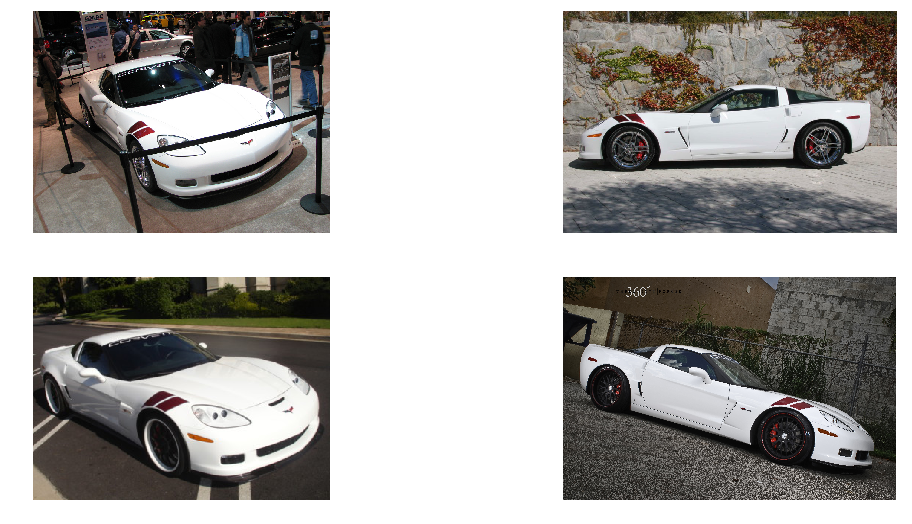

Chevrolet Corvette Ron Fellows Edition Z06 2007


In [14]:
# Look at several images from the training set
rand_cl = rng.choice(196)
print(train_dict[rand_cl][0:4])

fig=plt.figure(figsize=(18, 9))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    img = imageio.imread(train_dict[rand_cl][i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
plt.show() 

print(classes.get(rand_cl).values[0][0])

['car_ims/004595.jpg', 'car_ims/004596.jpg', 'car_ims/004597.jpg', 'car_ims/004598.jpg']


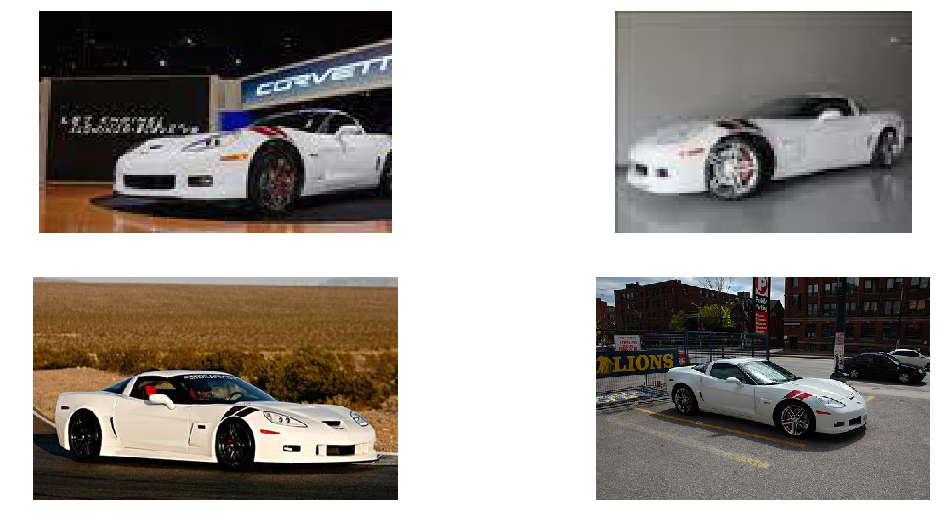

Chevrolet Corvette Ron Fellows Edition Z06 2007


In [15]:
# Look at several images from the testing set
print(test_dict[rand_cl][0:4])

fig=plt.figure(figsize=(18, 9))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    img = imageio.imread(test_dict[rand_cl][i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

print(classes.get(rand_cl).values[0][0])

In [16]:
# Make train and validation folders for fastai dataloader

if os.path.exists('./train'):
    shutil.rmtree('./train')
if os.path.exists('./valid'):
    shutil.rmtree('./valid')
    
!mkdir ./train
!mkdir ./valid

# Populate the class folders with images
for cl in train_dict.keys():
    train_folder = './train/' + str(cl) + "/"
    valid_folder = './valid/' + str(cl) + "/"
    if not os.path.exists(train_folder):
        os.mkdir(train_folder)
    if not os.path.exists(valid_folder):
        os.mkdir(valid_folder)
        
    for tr_img in train_dict[cl]:
        shutil.copy(tr_img, train_folder)
    for val_img in test_dict[cl]:
        shutil.copy(val_img, valid_folder)       

In [17]:
%%capture

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
#import skimage

In [18]:
def get_data(sz, bs=128, arch=resnet50, aug_tfms=transforms_side_on,
             max_zoom=1.05, num_workers=8):
    tfms = tfms_from_model(arch, sz, 
                       aug_tfms=aug_tfms, 
                       max_zoom=max_zoom)
    data = ImageClassifierData.from_paths('', bs=bs, tfms=tfms,
                                          num_workers=num_workers)
    return data

arch = resnet50
sz = 240
# Side on tranforms but increased a bit
aug_tfms = [RandomRotateZoom(deg=20, zoom=1.25, stretch=0.1)]
aug_tfms += [AddPadding(pad=20, mode=cv2.BORDER_CONSTANT)]
aug_tfms += [RandomLighting(0.1, 0.1)]
aug_tfms += [Cutout(n_holes=5, length=14, tfm_y=TfmType.NO)]
aug_tfms += [RandomFlip()]
#aug_tfms += [GoogleNetResize(targ_sz=sz)]

# Augmentations did next to nothing, so I loaded data with default tfms
data = get_data(sz, bs=128)

In [19]:
# Without precompute set to False, this gives bad results.
learn = ConvLearner.pretrained(arch, data, ps=[0.5,0.5], precompute=False)

Here I modified the default FastAI pipeline by enhancing the augmentations and increasing the dropout on the penultimate layer. Although I haven't extensively tested yet, the augmentations didn't seem to have much effect on overfitting compared to the dropout.

Precomputation seems to just make it much harder to train the entire network afterward, so any time saved on precomputation is not worth it.

In [20]:
learn.opt_fn = optim.Adam

In [21]:
learn.summary

<bound method ConvLearner.summary of Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), 

In [22]:
learn.freeze()

In [23]:
#lrf=learn.lr_find(wds = 1e-2, use_wd_sched=True, start_lr=1e-05, end_lr=10)

In [24]:
#learn.sched.plot(n_skip=0,n_skip_end=3)

This code will barely fit in a 16 GB P100 GPU. So I use empty_cache() in order to maximize the memory utilization.

In addition, running the learning rate finder takes up memory space so when testing a full model it is probably best to run the finders and then run the model all at once separately. 

In [25]:
#Use this to free more GPU memory after running training
torch.cuda.empty_cache()

In [26]:
result, ep_vals = learn.fit(3e-2, 1, cycle_len=10, use_clr_beta=(10, 10), wds=1e-1, use_wd_sched=True, get_ep_vals=True)

epoch      trn_loss   val_loss   accuracy                  
    0      4.230671   3.119171   0.252083  
    1      3.612597   2.776126   0.301952                  
    2      3.34394    2.719915   0.319363                  
    3      3.263703   2.647856   0.329188                  
    4      3.266452   2.643305   0.33466                   
    5      3.127491   2.423895   0.37172                   
    6      2.892045   2.21296    0.426688                  
    7      2.631479   2.044222   0.472329                  
    8      2.365978   1.887572   0.508021                  
    9      2.185354   1.840089   0.521453                  



I trained the head only until the training loss was about equal to the validation loss in order to avoid too much overfitting.

In [27]:
learn.unfreeze()
torch.cuda.empty_cache()

In [28]:
#lrf=learn.lr_find(wds = 3e-2, use_wd_sched=True, start_lr=1e-06, end_lr=10)
#learn.sched.plot(n_skip=0,n_skip_end=3)

In [29]:
torch.cuda.empty_cache()

In [30]:
lr2=1e-2

In [31]:
# This particular dataset seems to train better with
# somewhat higher learning rates in the lower layers,
# possibly because the Imagenet weights don't generalize
# to this dataset very well.
lrs = np.array([lr2/30,lr2/3,lr2])

In [32]:
result2, ep_vals2 = learn.fit(lrs, 1, cycle_len=25, use_clr_beta=(10, 20), wds=1e-1, use_wd_sched=True)

epoch      trn_loss   val_loss   accuracy                  
    0      3.054548   2.689753   0.31899   
    1      2.530399   2.730544   0.319363                  
    2      2.33888    2.292486   0.400945                  
    3      2.237952   2.808777   0.314886                  
    4      2.178724   2.253248   0.412511                  
    5      2.11488    3.080468   0.312275                  
    6      2.149359   2.43141    0.381793                  
    7      2.181406   2.581373   0.365875                  
    8      2.216436   2.302639   0.426315                  
    9      2.24613    2.570884   0.375078                  
    10     2.333206   2.145944   0.449198                  
    11     2.154269   1.660097   0.555404                  
    12     1.986559   1.679269   0.545455                  
    13     1.686372   1.309792   0.6391                    
    14     1.399283   1.128112   0.67902                   
    15     1.224369   0.866974   0.757244               

In [33]:
torch.cuda.empty_cache()

In [34]:
log_preds, y = learn.TTA()

In [35]:
probs = np.exp(log_preds)

In [36]:
avg_TTA = np.mean(probs, axis = 0)

In [176]:
preds = np.argmax(avg_TTA,axis=1)
pred_probs = np.max(avg_TTA,axis=1)
targs = y

In [170]:
TTA_acc = (preds==targs).mean()
print("Final accuracy: " + str(TTA_acc*100)[:5] + "%")

Final accuracy: 88.88%


TTA improved the accuracy very slightly, by about 1%.

In [197]:
#plt.hist(preds, bins=np.arange(196))

The worst predicted class is found by taking the mode of the targets that were missed:

In [195]:
from scipy.stats import mode
mode(y[np.where(preds != targs)])

ModeResult(mode=array([164]), count=array([22]))

In [196]:
print(classes.get(164).values[0][0])

Mercedes-Benz S-Class Sedan 2012


In [114]:
wrongs = np.where(preds != targs)[0]

Create bins so that the $N^{th}$ wrongly classified test image can be placed into a class using np.digitize or np.histogram:

In [198]:
cl_bins = np.insert(np.cumsum(list(map(len, test_dict.values()))),0,0)

In [192]:
# Find the top 5 worst classes predicted
worst_six = list(np.argsort(np.histogram(wrongs,bins=cl_bins)[0])[-6:])
cl_matcher = np.digitize(wrongs, cl_bins)-1
print(worst_six)
for worst in worst_six:
    print(classes.get(worst).values[0][0])

[36, 112, 91, 60, 146, 164]
BMW X3 SUV 2012
Ford F-150 Regular Cab 2012
Dodge Magnum Wagon 2008
Chevrolet Impala Sedan 2007
Jeep Liberty SUV 2012
Mercedes-Benz S-Class Sedan 2012


In [193]:
# Create a dictionary of the wrongly predicted images
wrg_dict = defaultdict(list)
for i, wrg in enumerate(wrongs):
    wrg_cl = cl_matcher[i]
    wrg_idx = wrg - cl_bins[wrg_cl]
    wrg_fnames = test_dict[wrg_cl]
    wrg_fname = wrg_fnames[wrg_idx]
    wrg_dict[wrg_cl].append(wrg_fname)

### Worst Performing Classes:
This section plots images of the worst performing classes (classes with the highest error rate).
On the left is a random wrongly classified image, and on the right is a random image from the class that the model guessed it belongs to. 

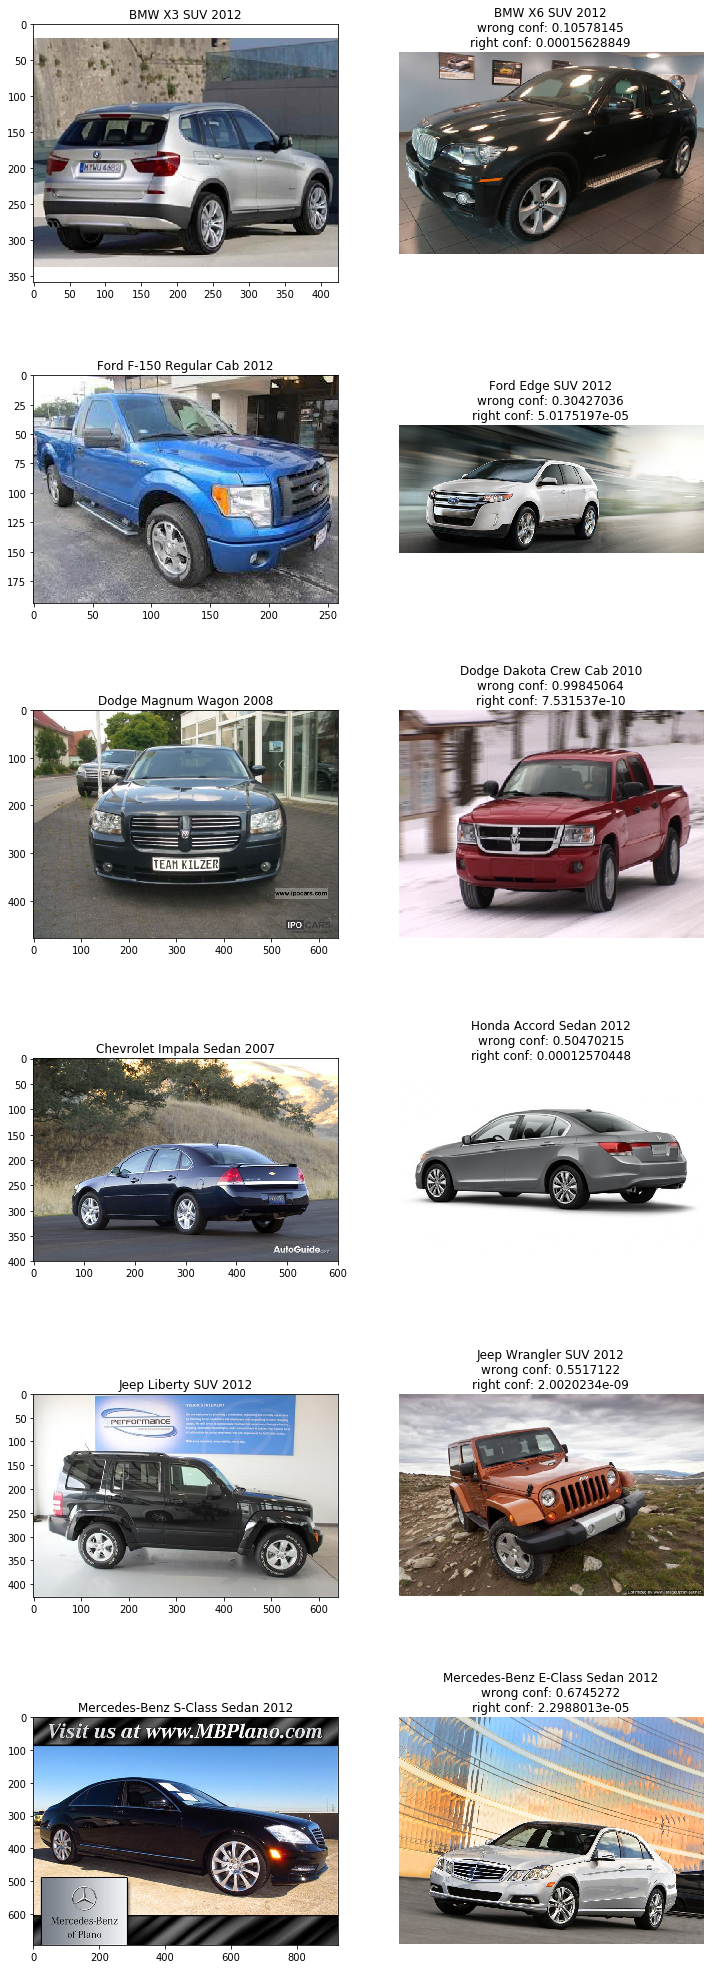

In [199]:
fig=plt.figure(figsize=(12,36))    
for i, worst in enumerate(worst_six):
    amnt = len(wrg_dict[worst])
    pick = rng.choice(amnt)
    img_num = pick + cl_bins[worst]
    actual = wrg_dict[worst][pick]
    pred_cl = preds[img_num]
    pred_pr = pred_probs[img_num]
    targ_pr = avg_TTA[img_num][worst]
    # just grab a random in the wrongly predicted class for illustration
    pred = test_dict[pred_cl][rng.choice(20)]
    act_img = imageio.imread(actual)
    pred_img = imageio.imread(pred)
    ax = fig.add_subplot(6, 2, 2*i+1)
    ax.set_title(classes.get(worst).values[0][0])
    plt.imshow(act_img)
    ax2 = fig.add_subplot(6, 2, 2*i+2)
    ax2.set_title(classes.get(pred_cl).values[0][0] + 
                  '\n' + 'wrong conf: ' + str(pred_pr) +
                  '\n' + 'right conf: ' + str(targ_pr))
    plt.imshow(pred_img)
    plt.axis('off')
plt.show()

It turns out that the worst predicted class was a Mercedes Benz S-Class and the classifier almost always chose Mercedes Benz E-Class. Since I can barely tell the difference as a human, it is unlikely that the model performance could be improved much there. The classifier also sometimes predicts some other classes that are fairly similar, for instance cars that are both made by the same company.

But occasionally it will do very poorly and predict a BMW as a Dodge, or a Ford as an Audi, etc. 
The classifier also usually doesn't get anywhere close to the correct result, because the "right class confidence" is always extremely low.

Re-running the plot section will show more failure examples on the right column (left column is always the correct class).